In [77]:
%pip install jax
%pip install py_vollib_vectorized
%pip install fastapi


/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
Python(96063) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Python(96064) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Python(96065) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 95 kB 420 kB/s eta 0:00:01
     |████████████████████████████████| 444 kB 536 kB/s eta 0:00:01
     |████████████████████████████████| 72 kB 806 kB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 729 kB/s eta 0:00:01
     |████████████████████████████████| 100 kB 2.1 MB/s ta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [79]:
import math
import jax.numpy as jnp
from __future__ import annotations
from jax import grad
from jax.scipy.stats import norm
from py_vollib.black import black
import py_vollib_vectorized
from polygon import RESTClient

from typing import Union
from fastapi import FastAPI

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from scipy.stats import norm
from polygon import RESTClient
import pandas as pd
import datetime
import yfinance as yf
import datetime as dt
from scipy.stats import norm
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np

from typing import Optional
from pydantic import BaseModel
from fastapi import FastAPI, HTTPException
from fastapi.responses import JSONResponse
from fastapi import Request

import base64
import io

In [80]:
def calc_d1(S: float, K: float, r: float, vol: float, T: float, t: float) -> float:
    num = jnp.log(S / K) + (r + 0.5*(vol) ** 2) * (T - t)
    denom = vol * jnp.sqrt(T - t)
    return num / denom


def calc_d2(S: float, K: float, r: float, vol: float, T: float, t: float) -> float:
    d1 = calc_d1(S, K, r, vol, T, t)
    return d1 - vol * jnp.sqrt(T - t)

# call options price
def blackScholesOptionPrice(S: float, K: float, r: float, vol: float, T: float, t: float) -> float:
    d1 = calc_d1(S, K, r, vol, T, t)
    d2 = calc_d2(S, K, r, vol, T, t)
    return S * norm.cdf(d1) - K * jnp.exp(-r * (T - t)) * norm.cdf(d2)


In [81]:
vega = grad(blackScholesOptionPrice, argnums = 3)


In [82]:
S = 100  # Spot price
K = 100  # Strike price
r = 0.05  # 5% risk-free rate
vol = 0.2  # 20% annual volatility
T = 1.0  # Maturity in 1 year
t = 0.0  # Current time


print(py_vollib_vectorized.models.vectorized_black_scholes("c", S, K, T, r, vol).iloc[0,0])
print(blackScholesOptionPrice(S, K, r, vol, T, t))

10.450583572185561
10.450577


In [123]:
# Now let's do this, we want to find the zero's of this function
def loss(S: float, K: float, r: float, vol: float, T: float, t: float, call_price: float) -> float:
    theoretical_price = blackScholesOptionPrice(S, K, r, vol, T, t)
    actual_price = call_price
    return theoretical_price - actual_price

def bisection_solve_for_implied_volatility(
                                    S: float, K: float, r: float, vol_left: float, vol_right: float, T: float, t: float,
                                    call_price: float,
                                    n_steps: int, tolerance: float, verbose: bool = False
                                ) -> float:
    MAX_VOL = 20.00
    MAX_INTERVAL_SIZE = 1e-6
    for _ in range(n_steps):
        f_left = loss(S, K, r, vol_left, T, t, call_price)
        f_right = loss(S, K, r, vol_right, T, t, call_price)
        
        if f_left * f_right > 0:
            vol_left = vol_left - (vol_left - 0) / 2
            vol_right = vol_right + (MAX_VOL - vol_right) / 2
            if vol_right > MAX_VOL:
                raise ValueError("vol_right is greater than the maximum allowed volatility in bisection solver :(")
            continue 

        vol_mid = (vol_right + vol_left) / 2
        f_mid = loss(S, K, r, vol_mid, T, t, call_price)

        if (verbose):
            print(f"Currently solving the problem using Bisection, current value of diff between Expected and Actual: {f_mid:.6f}")

        if abs(f_mid) < tolerance:
            return vol_mid
        
        if f_left * f_mid < 0:
            vol_right = vol_mid
        else:
            vol_left = vol_mid

        if abs(vol_right - vol_left) < MAX_INTERVAL_SIZE:
            raise ValueError("Interval to small when performing BISECTION method :(")
        
    # incase we do not converge
    if (verbose):
        print(f"Warning: IV did not converge for S={S}, K={K}, price={call_price}, returning None")
        
    return np.nan



bisection_solve_for_implied_volatility(
    S, K, r, 1e-6, 20.00, T, t,
    80.00, 100, 1e-3, True
)

Currently solving the problem using Bisection, current value of diff between Expected and Actual: 19.999939
Currently solving the problem using Bisection, current value of diff between Expected and Actual: 18.788780
Currently solving the problem using Bisection, current value of diff between Expected and Actual: -0.605766
Currently solving the problem using Bisection, current value of diff between Expected and Actual: 14.071213
Currently solving the problem using Bisection, current value of diff between Expected and Actual: 8.475739
Currently solving the problem using Bisection, current value of diff between Expected and Actual: 4.430771
Currently solving the problem using Bisection, current value of diff between Expected and Actual: 2.042938
Currently solving the problem using Bisection, current value of diff between Expected and Actual: 0.751907
Currently solving the problem using Bisection, current value of diff between Expected and Actual: 0.081482
Currently solving the problem usi

2.534333148674011

In [124]:
client = RESTClient(api_key="bYx0g7_YgYXQsq1msFy5zo8KmEAXpc1y")

In [125]:
def options_chains(ticker):
    asset = yf.Ticker(ticker)
    expirations = asset.options
    chains = (
        pd.DataFrame()
    )  # tuple of strings of dates i.e ("2025-06-20", ..., "2025-07-03")
    for expiration in expirations:
        # tuple of two dataframes
        opt = asset.option_chain(
            expiration
        )  # what is an option chain object?? (https://www.investopedia.com/terms/o/optionchain.asp)
        calls = opt.calls
        calls["optionType"] = "call"
        puts = opt.puts
        puts["optionType"] = "put"

        chain = pd.concat([calls, puts])
        chain["expiration"] = pd.to_datetime(expiration) + pd.DateOffset(
            hours=23, minutes=59, seconds=59
        )  # sets the expiration to the next day
        chains = pd.concat([chains, chain])
    chains["daysToExpiration"] = (
        chains.expiration - dt.datetime.today()
    ).dt.days + 1  # calculates days till expiration

    chains = chains[chains["optionType"] == "call"]
    chains["T"] = chains["daysToExpiration"] / 365

    stock = yf.Ticker("TSLA")
    price = stock.info["regularMarketPrice"]
    chains["S0"] = price

    chains["K"] = chains["strike"]

    # you should use the risk free rate corresponding to the lending period, for example if we are lending 1-3 months we use SHV (iShares Short Treasury ETF)
    # SHY for 1-3 years, etc.
    # use FRED API for more accurate treasury rates

    # 1-3 month ETF
    ticker = yf.Ticker("SHV")
    info = ticker.info
    latest_r_one_to_three_months = info.get("dividendYield")
    print(
        f"Latest close price for SHV ETF (1-3 month ETF): {latest_r_one_to_three_months}"
    )

    # 1-3 years ETF
    ticker = yf.Ticker("SHY")
    info = ticker.info
    latest_r_one_to_three_years = info.get("dividendYield")
    print(
        f"Latest close price for SHV ETF (1-3 year ETF): {latest_r_one_to_three_years}"
    )

    # Now that we have approximations for the risk-Free rate, we can begin to
    THREE_MONTH_T = (
        0.2548  # this is approximately 3*31 / 365  (i.e 3 months in days / 365)
    )
    chains["r"] = np.where(
        chains["T"] > THREE_MONTH_T,
        latest_r_one_to_three_years,
        latest_r_one_to_three_months,
    )  # conditionally set the risk free rate for the data
    return chains

In [148]:
def get_market_data(ticker: str):
    chains = options_chains(ticker)
    chains = chains.reset_index(drop=True)
    chains = chains.dropna()
    coords = []
    N_STEPS = 100
    tolerance = 1e-3
    for index, row in chains.iterrows():
        T, S0, K, r, C_mkt = row["T"], row["S0"], row["K"], row["r"], row["lastPrice"]

        lower_bound = max(0, S0 - K*math.exp(-r*T))
        upper_bound = S0

        if not (lower_bound <= C_mkt <= upper_bound):
            continue

        moneyness = S0 / K
        time_to_expiry = T

        implied_vol = bisection_solve_for_implied_volatility(
            S0, K, r, 1e-6, 5.00, T, t, C_mkt, N_STEPS,
            tolerance, False
        )

        if implied_vol == np.nan or implied_vol <= 0 or implied_vol > 5.0:
            continue 

        coords.append({
            "Moneyness": moneyness,
            "Time to Expiry": time_to_expiry,
            "Implied Volatility": implied_vol
        })

    coords = pd.DataFrame(coords)
    coords.dropna(inplace=True)

    x = coords["Moneyness"].values
    y = coords["Time to Expiry"].values
    z = coords["Implied Volatility"].values

    # Create a 2D grid for x and y
    xi = np.linspace(min(x), max(x), 100)
    yi = np.linspace(min(y), max(y), 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate z values
    zi = griddata((x, y), z, (xi, yi), method="cubic")
    zi = np.clip(zi, 0, None)

    zi = np.nan_to_num(zi, nan=np.nanmean(zi))

    response = (xi, yi, zi)
    return response


In [149]:
response = get_market_data("TSLA")

Latest close price for SHV ETF (1-3 month ETF): 4.69
Latest close price for SHV ETF (1-3 year ETF): 3.95


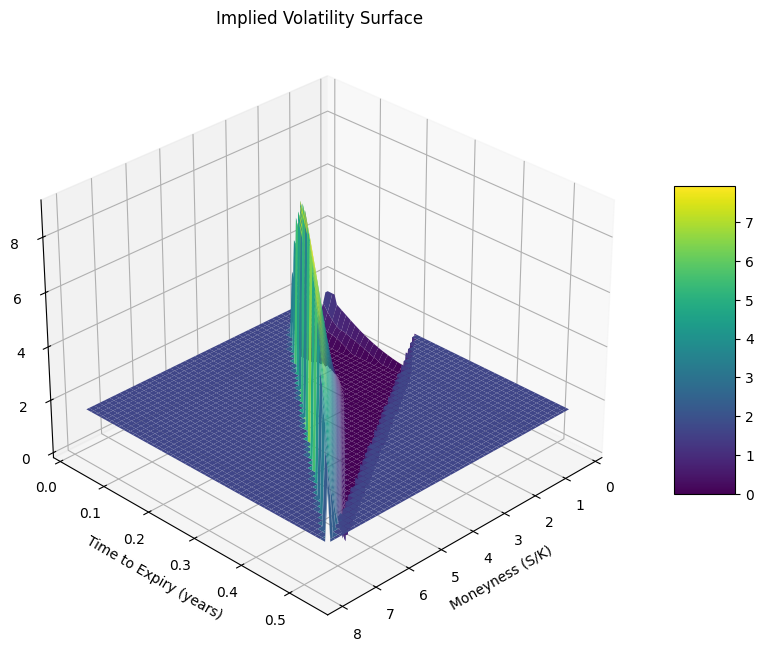

In [150]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(response[0], response[1], response[2], cmap="viridis", edgecolor="none")

ax.set_xlabel("Moneyness (S/K)")
ax.set_ylabel("Time to Expiry (years)")
ax.set_zlabel("Implied Volatility")
ax.set_title("Implied Volatility Surface")

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.view_init(elev=30, azim=45)

plt.show()

In [ ]:
plt.